## Sample Workflow

In [66]:
# Set Project Root
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)


# %run "$BASE_DIR/settings.py"


%config InlineBackend.figure_format = 'png'

# import my method from the source code
# from features.build_features import remove_invalid_data
# from features.build_features import awesome_function

#TODO put tqdm progress bars in here


import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly as plty

import missingno as msno

from wordcloud import WordCloud
from pandas_profiling import ProfileReport

import html
import re

# Textacy
import textacy.preprocessing as tprep # Preprocesing of accents/normalization
from textacy.preprocessing.resources import RE_URL

import nltk
from nltk.tokenize import RegexpTokenizer

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

# Set to Reload all custom packages
%load_ext autoreload
%autoreload 2


# Custom developed tools
import nlp_tools
import constants

nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline


g:\My Drive\Code\springboard_proj_nlp_nytimes
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load up data

In [5]:
# Load Sample Data
df_test = pd.read_pickle('..//data//processed//df_test_sample.pkl')
df_train = pd.read_pickle('..//data//processed//df_train_sample.pkl')
df_comments = pd.read_pickle('..//data//processed//df_comments_sample.pkl')
df_articles = pd.read_pickle('..//data//processed//df_articles_sample.pkl')

# # Load Real Data
# # df_test = pd.read_pickle('..//data//raw//df_test.pkl')
# # df_train = pd.read_pickle('..//data//raw//df_train.pkl')
# df_comments = pd.read_pickle('..//data//raw//df_comments.pkl')
# df_articles = pd.read_pickle('..//data//raw//df_articles.pkl')


# Drop constant columns, userTitle is 99% empty
df_comments.drop(columns=['status','trusted','recommendedFlag','isAnonymous','userTitle'],inplace=True)


# Convert Timestamps where necessary
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])
df_comments['createDate'] = pd.to_datetime(df_comments['createDate'])
df_comments['updateDate'] = pd.to_datetime(df_comments['updateDate'])
df_comments['approveDate'] = pd.to_datetime(df_comments['approveDate'])



TODO make data columns dates

In [7]:
df_articles.head(3).T

,15829,1097,11541
newsdesk,Climate,Politics,Well
section,Climate,U.S.,Well
subsection,NaN,Politics,Move
material,News,News,News
headline,Trump Administration Is Planting Loyalists in ...,"Sanders Seizes Lead in Volatile Iowa Race, Tim...","For Successful Aging, Pick Up the Pace or Mix ..."
abstract,Supporters of the president are monitoring man...,"With solid support from liberals, Mr. Sanders ...",Older people who cycled for exercise walked mo...
keywords,"['Global Warming', 'Environment', 'Greenhouse ...","['Iowa', 'Democratic Party', 'Presidential Ele...","['Exercise', 'Running', 'Longevity', 'Age, Chr..."
word_count,1180,1714,901
pub_date,2020-12-08 23:24:22+00:00,2020-01-25 10:00:11+00:00,2020-09-02 09:00:13+00:00
n_comments,479,791,518


In [8]:
df_comments.head().T


,2893132,2599853,125068,2425848,1444275
commentID,108107200,107731134,104552271,107493366,106241790
commentSequence,108107200,107731134,104552271,107493366,106241790
userID,22178100,55663429,61505299,55596960,68597593
userDisplayName,kdw,Michael,Tsumomi,FilmFan,Andie
userLocation,"Louisville, KY",Ottawa,"Portland, OR",Y’allywood,"Geneva, NY"
commentBody,@Jo Williams Exactly I see a nightmarish Gotha...,@Bugmon \n\nAre you really that obtuse?\n\nI d...,It's so sad to see Trump's impact on our natio...,The children’s hospital in my city has enormou...,I can't wait to watch this virtually with othe...
createDate,2020-07-13 15:33:55,2020-06-23 01:09:24,2020-01-10 06:21:20,2020-06-08 15:03:28,2020-04-03 15:25:21
updateDate,2020-07-14 16:47:04,2020-06-25 10:27:26,2020-01-11 20:01:58,2020-06-09 15:40:03,2020-04-05 04:31:06
approveDate,2020-07-13 16:11:46,2020-06-23 01:27:44,2020-01-10 06:21:22,2020-06-08 15:03:29,2020-04-03 15:25:22
recommendations,2,1,44,78,8


### Join Articles to Comments

In [9]:
df_articles.iloc[0]

newsdesk                                                Climate
section                                                 Climate
subsection                                                  NaN
material                                                   News
headline      Trump Administration Is Planting Loyalists in ...
abstract      Supporters of the president are monitoring man...
keywords      ['Global Warming', 'Environment', 'Greenhouse ...
word_count                                                 1180
pub_date                              2020-12-08 23:24:22+00:00
n_comments                                                  479
uniqueID      nyt://article/95f224dd-f15f-5f98-ba28-159c3107...
Name: 15829, dtype: object

In [10]:
id = df_articles.iloc[0]['uniqueID']
id

'nyt://article/95f224dd-f15f-5f98-ba28-159c3107ce7c'

In [11]:
def getComments(uniqueid):
    '''
    Provide Unique ID of an article and receive dataframe of the comments for that article
    '''
    
    return df_comments[df_comments['articleID'] == uniqueid].sort_values(by='createDate')


In [12]:
getComments(id).head().T

,4741253,4741151,4741140,4741335,4741193
commentID,110520391,110520503,110522242,110523785,110524934
commentSequence,110520391,110520503,110522242,110523785,110524934
userID,18652124,55823171,34089796,88651488,101928298
userDisplayName,Katrina,Guy Walker,Ramona Lopez-Morrison,Diego4ever,Drew
userLocation,"Lexington, KY",New York City,"Omaha, Nebraska",San Diego,Bay Area
commentBody,"A bit off topic, but I couldn’t help but notic...",Members of said Crazytown. \nThey will do any...,During almost four years we amply witnessed wh...,All these articles about the transition read l...,"@Lars \n\n""Just state it plainly and let the c..."
createDate,2020-12-09 14:34:37,2020-12-09 14:38:35,2020-12-09 15:41:54,2020-12-09 16:41:12,2020-12-09 17:26:42
updateDate,2020-12-10 19:19:35,2020-12-09 19:49:20,2020-12-09 19:42:45,2020-12-09 18:23:32,2020-12-09 20:22:09
approveDate,2020-12-09 16:29:54,2020-12-09 15:42:21,2020-12-09 15:41:55,2020-12-09 17:15:29,2020-12-09 19:37:37
recommendations,36,10,11,5,2


# EDA

# Visualization
comments - numerics: [dates, recommendations, replyCount,depth,recommendedFlag] 
         - boolean: [editorsSelection]

articles - numerics - [word_count, pub_date, n_comments]

Ideas
    - All tables
      - Timeseries aggregations
      - 
 
    - df_comments
      - editorsSelection is boolean
      - userLocation might be interesting per topic
      - recommendations (numeric)
      - replyCount
      - depth
      - trusted/recommended
      - isAnonymous by topic

    - df_articles
      - Distribution of wordcount
      - pub_date is time series
      - n_comments
- comments  - Aggregated time series
    - - Group by month
            
- Counts by Subsection, and section

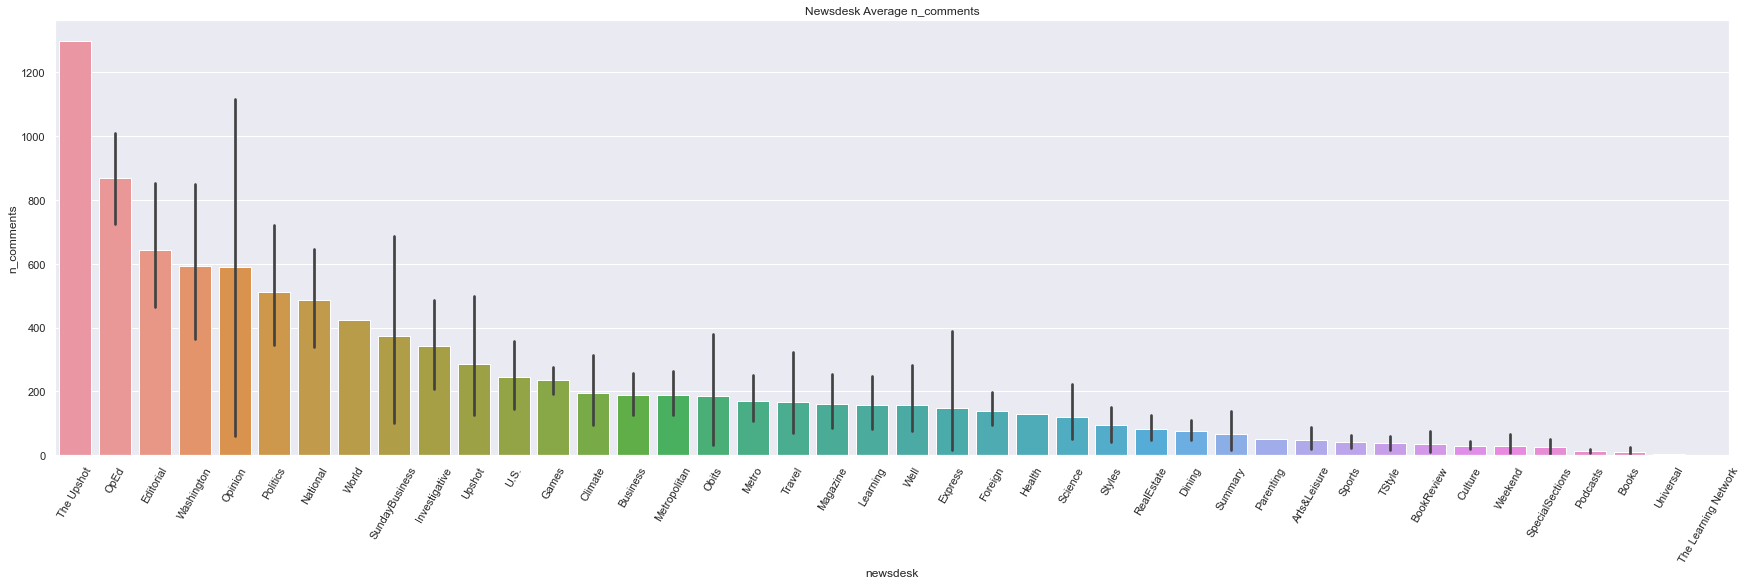

In [13]:
# Find the descending order of newsdesk categories with respect to n_comment mean
gp_articles_newsdesk_com = df_articles.groupby('newsdesk')['n_comments'].mean().sort_values(ascending=False)
order_comments = pd.Series(gp_articles_newsdesk_com.index)
gp_articles_newsdesk_com.head()

### Number of comments by Newsdesk
sns.set(rc = {'figure.figsize':(30,8)})
ax = sns.barplot(data=df_articles,x='newsdesk',y='n_comments',order=order_comments)
ax.set_title('Newsdesk Average n_comments')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

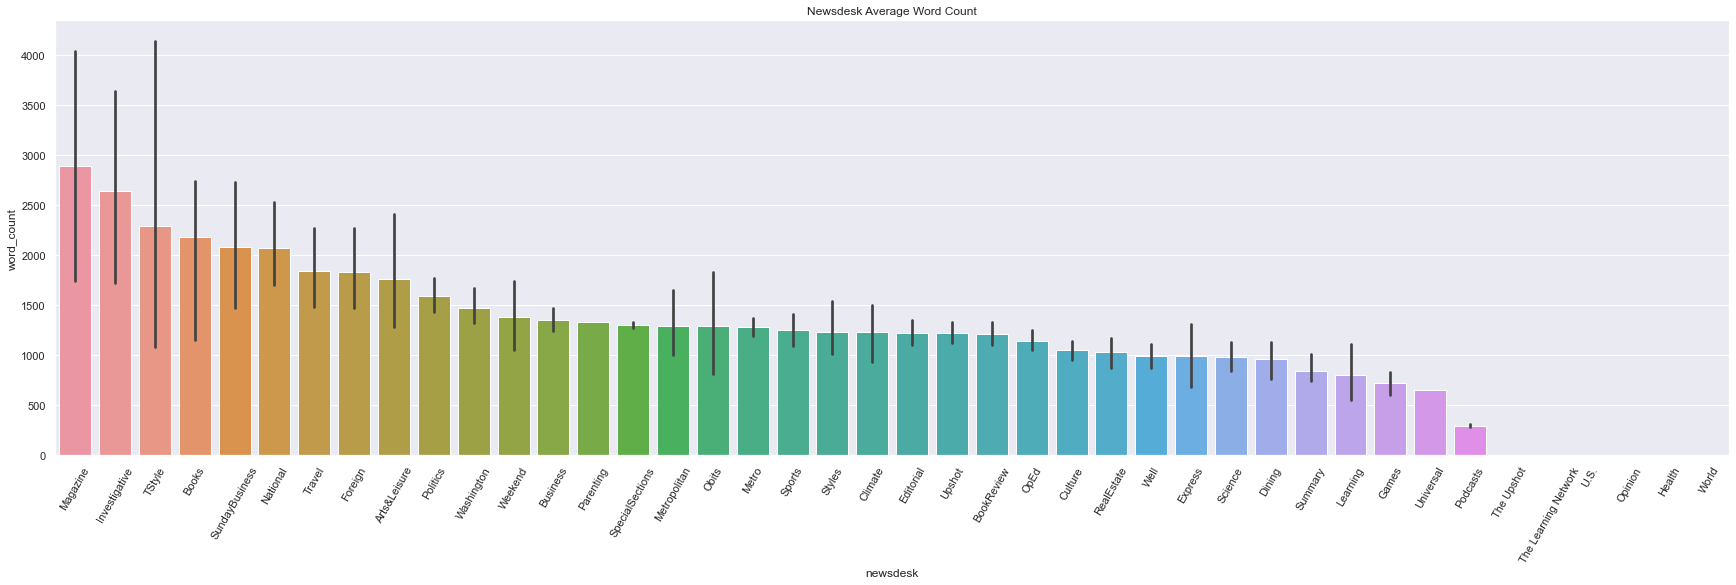

In [14]:
# Find the descending order of newsdesk categories with respect to word_count mean
gp_articles_newsdesk_wc = df_articles.groupby('newsdesk')['word_count'].mean().sort_values(ascending=False)
order_wc = pd.Series(gp_articles_newsdesk_wc.index)
gp_articles_newsdesk_wc.head()

### Number of word counts by Newsdesk
sns.set(rc = {'figure.figsize':(30,8)})
ax = sns.barplot(data=df_articles,x='newsdesk',y='word_count',order=order_wc)
ax.set_title('Newsdesk Average Word Count')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

### Newsdesk and distribution of number of comments

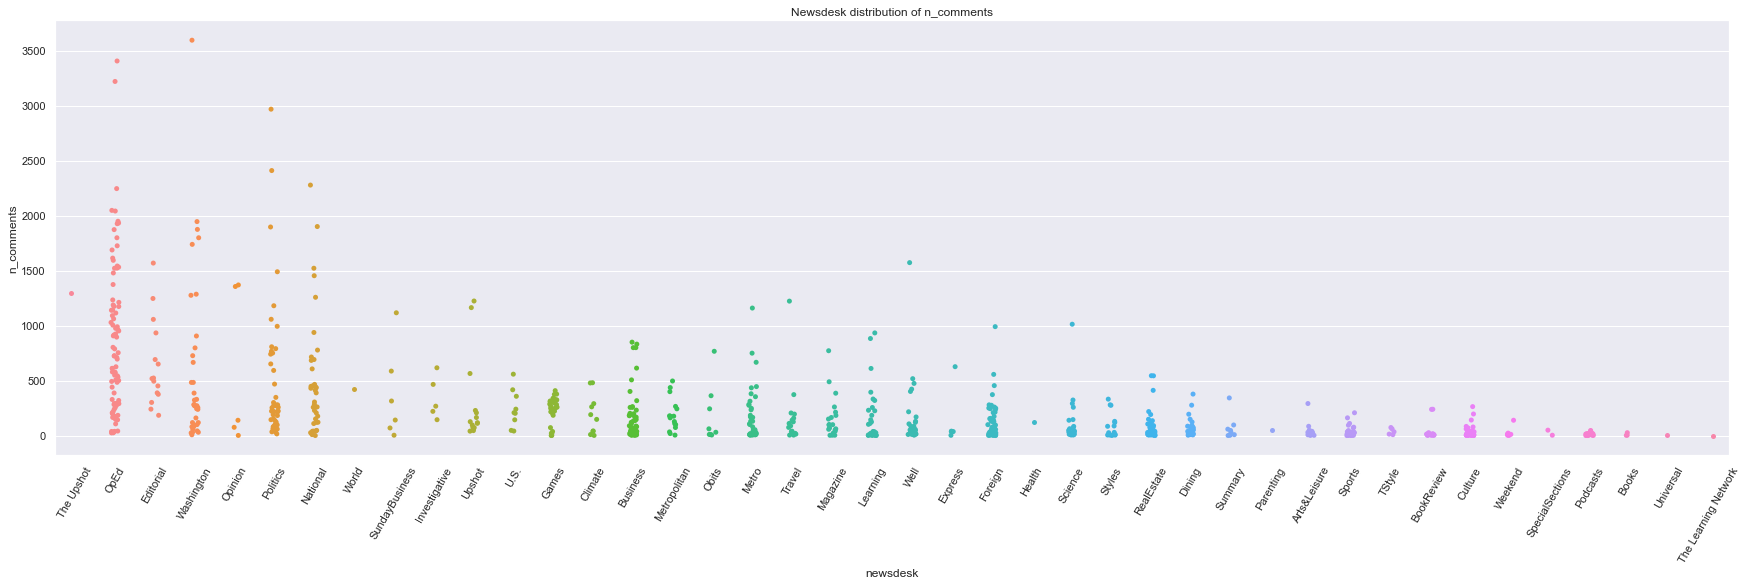

In [15]:
sns.set(rc = {'figure.figsize':(30,8)})
ax = sns.stripplot(data=df_articles,x='newsdesk',y='n_comments',order=order_comments)
ax.set_title('Newsdesk distribution of n_comments')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

### Number of comments by Material

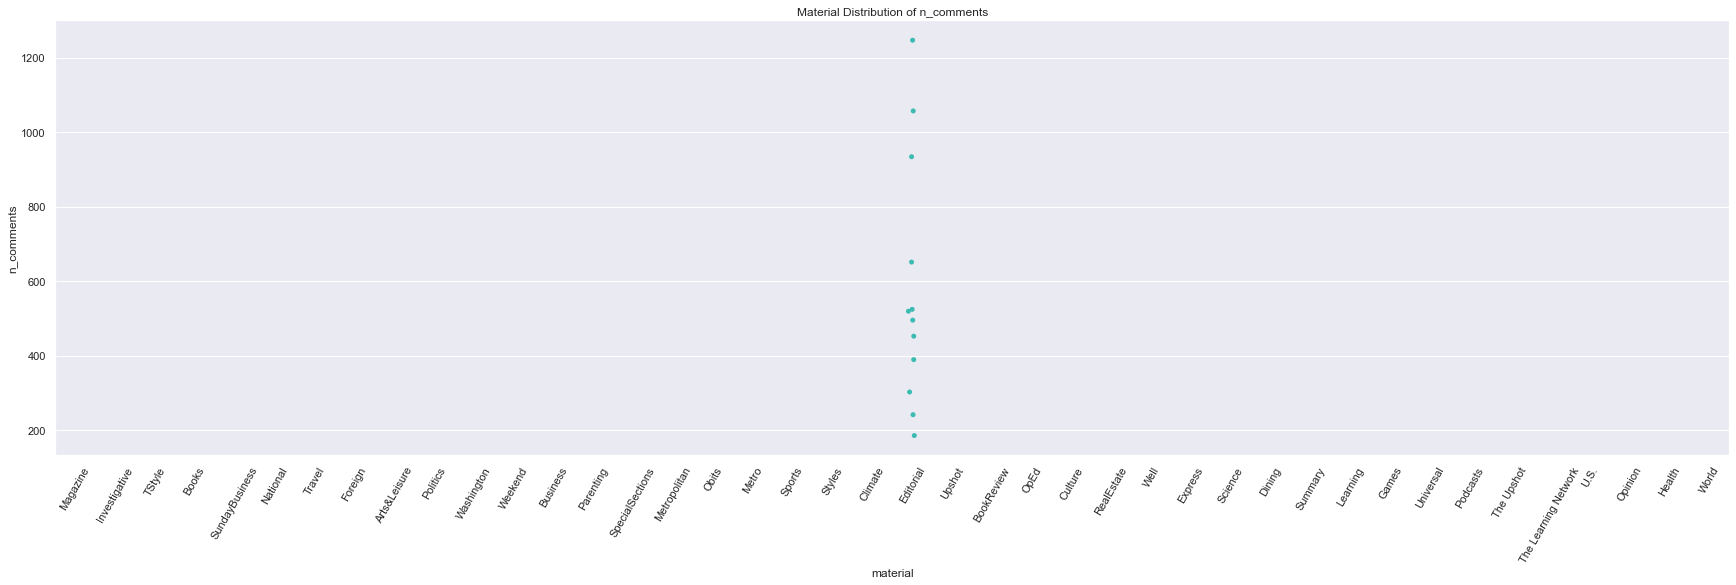

In [16]:
sns.set(rc = {'figure.figsize':(30,8)})
ax = sns.stripplot(data=df_articles,x='material',y='n_comments',order=order_wc)
ax.set_title('Material Distribution of n_comments')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

### Relationship between word count and number of comments?

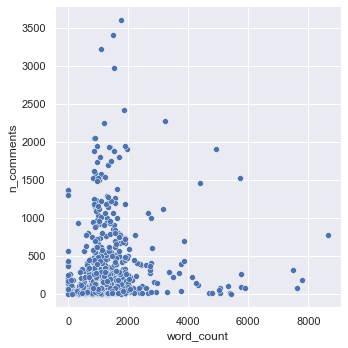

In [17]:
sns.set(rc = {'figure.figsize':(1,1)})
sns.relplot(data=df_articles,x='word_count',y='n_comments')

# Processing / Feature Engineering

### Cleaning

In [37]:

# WORKS 
pipeline = [
                nlp_tools.clean,
                nlp_tools.expandContraction,
                nlp_tools.normalize,
                nlp_tools.tokenizeText,
                nlp_tools.cleanStopWords,
                nlp_tools.lemmatizeTokenList
            ]

# Choices
# First Tokenize
# Then Pipeline

# Scenario

# Tokenize creates list
# Lower Case (str.lower)
# 

# Call like this
#df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

def prepare(text_list, pipeline):
    """Iterate over the functions

    Args:
        text_list ([type]): [description]
        pipeline ([type]): [description]

    Returns:
        [type]: [description]
    """
    tokens = text_list
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [71]:
df_comments['commentTokenized'] = df_comments['commentBody'].apply(prepare, pipeline=pipeline)

In [69]:
df_comments['commentBody'].iloc[50]

"Nobody has the right to inflict disease on other people because of their religious or other unscientific beliefs.\n\nIf people don't vaccinate their children, they need to home school them and keep them away from public spaces.  That means, no playgrounds, no petting zoos, no grocery stores.  No McDonald's.  Hey, and guess what?  No doctor's offices.  No hospitals."

In [72]:
# What is the word count per topic, articles then subsequent topic or keyword
nlp_tools.count_words(df_comments,column='commentTokenized')

,freq
token,
i,43417
trump,18893
the,16198
people,13928
would,10412
...,...
cna,2
brotherly,2
scoot,2


In [74]:
 nlp_tools.count_words(df_comments, column='commentBody',
                preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
government,2818
Republicans,2230
Republican,2148
understand,1374
Democratic,1340
...,...
thetruthfirst,2
United_Nations_Human_Rights_Council,2
artanddesign,2


In [79]:
 # Only text that has 10 or more letters
 word_count_df = nlp_tools.count_words(df_articles, column='abstract',
                preprocess=lambda text: re.findall(r"\w{10,}", text))

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

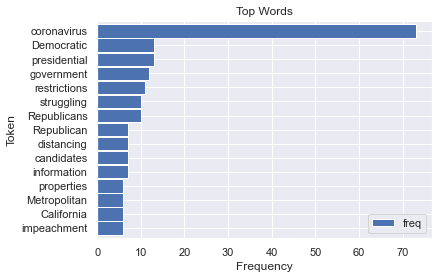

In [80]:
ax = word_count_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Do this rolling per month?  Per Category?

## TF-IDF 
https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch01.html#idm46749294825064

In [86]:
nlp_tools.compute_idf(df_comments, column='commentBody',preprocess=lambda text: re.findall(r"\w{3,}", text),min_df=2).sort_values(by='')

g:\My Drive\Code\springboard_proj_nlp_nytimes\notebooks\..\src\nlp_tools.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df.index.name = 'token'


,df,idf
token,,
Batman,3,9.818462
help,1678,3.491717
all,9824,1.724491
nightmarish,9,8.719850
City,215,5.546437
...,...,...
356,2,10.223927
TENS,2,10.223927
Spider,2,10.223927


## Impurity Counts

Calculate what percentage of the text is not 'pure' and provide that metric into dataframe

In [39]:
df_comments['CLEAN_impurity'] = df_comments['commentBody'].apply(nlp_tools.impurity)

In [77]:
max(df_comments['CLEAN_impurity'])

0.10526315789473684

Clean any non-clean characters

In [80]:
df_comments['CLEAN_normalized_2'] = df_comments['commentBody'].apply(nlp_tools.clean)

In [97]:
df_comments['CLEAN_normalized_2']

2893132    @Jo Williams Exactly I see a nightmarish Gotha...
2599853    @Bugmon Are you really that obtuse? I do wear ...
125068     It's so sad to see Trump's impact on our natio...
2425848    The children's hospital in my city has enormou...
1444275    I can't wait to watch this virtually with othe...
                                 ...                        
3009694              Best last sentence in any column, ever.
592853     Roger Stone, along with Paul Manafort and Lee ...
1359418    No one individual tweets 798 times in a day. I...
4886496    @Anthony Or the lives of journalists and civil...
463789     I believe Senator Klobuchar's act of sharing a...
Name: CLEAN_normalized_2, Length: 49865, dtype: object

Normalize text

In [88]:
df_comments['CLEAN_tokenized_3'] = df_comments['CLEAN_normalized_2'].apply(nlp_tools.tokenizeText)

Stop Words

In [95]:
df_comments['CLEAN_nostopwords_4'] = df_comments['CLEAN_tokenized_3'].apply(nlp_tools.cleanStopWords)
df_comments['CLEAN_nostopwords_4']

2893132    [@Jo, Williams, Exactly, I, see, nightmarish, ...
2599853    [@Bugmon, Are, really, obtuse, ?, I, wear, mas...
125068     [It, 's, sad, see, Trump, 's, impact, nation, ...
2425848    [The, children, 's, hospital, city, enormous, ...
1444275    [I, 't, wait, watch, virtually, folks, ., My, ...
                                 ...                        
3009694           [Best, last, sentence, column, ,, ever, .]
592853     [Roger, Stone, ,, along, Paul, Manafort, Lee, ...
1359418    [No, one, individual, tweets, 798, times, day,...
4886496     [@Anthony, Or, lives, journalists, civilians, ?]
463789     [I, believe, Senator, Klobuchar, 's, act, shar...
Name: CLEAN_nostopwords_4, Length: 49865, dtype: object

# Clean escapes

In [33]:
import nlp_tools
df_comments['commentClean'] = df_comments['commentBody'].apply(nlp_tools.clean)

# Tokenize / Split words

In [34]:
df_comments['commentTokens'] = df_comments['commentClean'].apply(nlp_tools.tokenizeText)
df_comments.head(1)

,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,commentBody,createDate,updateDate,...,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,articleID,commentClean,commentTokens
2893132,108107200,approved,108107200,22178100,kdw,"Louisville, KY",NaN,@Jo Williams Exactly I see a nightmarish Gotha...,2020-07-13 15:33:55,2020-07-14 16:47:04,...,Jo Williams,2,userReply,0,0,108107200,False,nyt://article/ceee4614-2a34-5964-afa8-e6c1aa2c...,@Jo Williams Exactly I see a nightmarish Gotha...,"[@Jo, Williams, Exactly, I, see, a, nightmaris..."


# Lemmatize Tokens

In [38]:
df_comments['commentLemmas'] = df_comments['commentTokens'].apply(nlp_tools.lemmatizeTokenList)
df_comments.head(1)

,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,commentBody,createDate,updateDate,...,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,articleID,commentClean,commentTokens,commentLemmas
2893132,108107200,approved,108107200,22178100,kdw,"Louisville, KY",NaN,@Jo Williams Exactly I see a nightmarish Gotha...,2020-07-13 15:33:55,2020-07-14 16:47:04,...,2,userReply,0,0,108107200,False,nyt://article/ceee4614-2a34-5964-afa8-e6c1aa2c...,@Jo Williams Exactly I see a nightmarish Gotha...,"[@Jo, Williams, Exactly, I, see, a, nightmaris...","[@jo, williams, exactly, i, see, a, nightmaris..."


# Remove Stop Words

In [46]:
df_comments['commentNoStopWords'] = df_comments['commentLemmas'].apply(nlp_tools.cleanStopWords)
df_comments['commentNoStopWords']

2893132    [@jo, williams, exactly, see, nightmarish, got...
2599853    [@bugmon, really, obtuse, ?, wear, mask, go, ....
125068     ['s, sad, see, trump, 's, impact, nation, ., w...
2425848    [children, ’s, hospital, city, enormous, cash,...
1444275    ['t, wait, watch, virtually, folks, ., grandmo...
                                 ...                        
3009694           [best, last, sentence, column, ,, ever, .]
592853     [roger, stone, ,, along, paul, manafort, lee, ...
1359418    [one, individual, tweet, 798, time, day, ., ’s...
4886496          [@anthony, live, journalists, civilians, ?]
463789     [believe, senator, klobuchar, ’s, act, share, ...
Name: commentNoStopWords, Length: 49865, dtype: object

In [20]:
text

'As a Foreign Officer I was proud to represent my country overseas. During my 60+ years associated with Eisenhower Fellowships, which has brought over 2,000 outstanding Fellows to the United States, I was proud to see them observe our American democracy. I often would chide my British relatives for not appreciating the ‘American way.’ After four years of Trump, I have been handed a sharp comeuppance. We are the laughing stock of the world. Our former traditional allies are dismayed by Trump’s abandonment of core principles of common self interest. Authoritarians such as Putin, Kim, Erdogan, and Mohamed bin Salman are laughing, while they play Trump like an accordion. I recall FDR’s Four Freedoms in 1941. We need Biden reaffirm these freedoms and to stabilize Trump’s shaky ship of state. We must return the United States to the concert of nations that share what had been our decency, our principles, and our alacrity to work with others to protect the oppressed and punish the oppressors.'